<a href="https://colab.research.google.com/github/mbajdman/Data-Science-Portfolio/blob/main/Property_Click_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Property Click Prediction

Our goal is to understand and predict property interactions using statistical modeling. We aim to develop a model that forecasts the number of interactions a property will receive within a specific timeframe. To simplify, we'll focus on predicting interactions within 3 and 7 days of a property's activation.

## Project Overview
This project aims to develop a statistical model that predicts the number of interactions a property will receive within a specific timeframe. By analyzing historical property data and interaction patterns, we strive to build a robust prediction system for property engagement.

## Project Goals

* Develop a predictive model that forecasts the number of interactions a property will receive within 3 and 7 days of its activation.
* Explore various statistical modeling techniques to identify the most accurate and efficient approach.
* Evaluate model performance using relevant metrics such as Root Mean Squared Error (RMSE) and R-squared.
* Gain insights into the key factors influencing property interactions and identify potential areas for optimization.

##Read and Explore all Datasets
First, we'll start with importing the necessary libraries and then reading all data. We have three datasets:

property dataset that contains various features like activation date, BHK type, locality, property size, property age, rent, apartment type, etc.;
property photos containing photo counts of properties;
property interactions containing the timestamps of interaction on the properties;

In [ ]:
# Import the pandas library as pd
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json

# View options for pandas
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 10)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Load data
properity_data_path = '/content/drive/MyDrive/Colab Notebooks/Properity Click Prediction/property_data_set.csv'
property_interactions_path = '/content/drive/MyDrive/Colab Notebooks/Properity Click Prediction/property_interactions.csv'
property_photos_path = '/content/drive/MyDrive/Colab Notebooks/Properity Click Prediction/property_photos.tsv'

Mounted at /content/drive


In [ ]:
data = pd.read_csv(properity_data_path)
interaction = pd.read_csv(property_interactions_path)
pics = pd.read_csv(property_photos_path, sep='\t')

In [ ]:
# Print shape of datasets
print('Property data Shape', data.shape)
print('Pics data Shape',pics.shape)
print('Interaction data Shape',interaction.shape)

Property data Shape (28888, 21)
Pics data Shape (28888, 2)
Interaction data Shape (170611, 2)


We can see that:

* property dataset has 28888 rows and 21 columns;
* property photos dataset has 28888 rows and 2 columns;
* property interactions dataset has 170611 rows and 2 columns;

In [ ]:
# Sample of property data
data.sample(2)

,property_id,type,activation_date,bathroom,floor,total_floor,furnishing,gym,latitude,longitude,lease_type,lift,locality,parking,property_age,property_size,swimming_pool,pin_code,rent,deposit,building_type
18833,ff8081815a8e1e6a015a8e1f5d47003e,BHK2,02-03-2017 15:41,2,1,3.0,SEMI_FURNISHED,0,12.932843,77.487080,ANYONE,0,Kengeri Satellite Town,BOTH,0,1000,0,560060.0,16000,160000,IF
12419,ff8081815a271e9c015a27ee0933409b,BHK2,10-02-2017 19:46,2,2,2.0,SEMI_FURNISHED,0,12.909373,77.572726,ANYONE,0,JP Nagar,BOTH,5,1100,0,560078.0,12000,120000,IF


In [ ]:
# Sample of pics data
pics.sample(2)

,property_id,photo_urls
21621,ff8081815ab0aa10015ab1ea4681608f,NaN
16005,ff8081815a5f9f4c015a6091500201b1,NaN


In [ ]:
# Sample of interaction data
interaction.sample(2)

,property_id,request_date
100447,ff8081815a5f9f4c015a6043b3212c94,2017-03-07 17:16:33
100852,ff8081815a5fa1e6015a5fe0c41033a0,2017-02-23 23:20:12


##Data Engineering
Let's perform several preprocessing steps in this Data Engineering section to create one dataset that contains all the features. These steps will include:

* Handling pictures data
* Finding the number of interactions within 3 days
* Finding the number of interactions within 7 days
* Dividing interactions into categories
* Merging all the datasets

##Handling Pics Data
In this step, the `photo_urls` column contains string values that we have to parse to obtain the number of photos uploaded on a property, let's see in the following steps.

In [ ]:
# Show the first five rows
pics.head()

,property_id,photo_urls
0,ff808081469fd6e20146a5af948000ea,"[{\title\"":\""Balcony\"",\""name\"":\""IMG_20131006..."
1,ff8080814702d3d10147068359d200cd,NaN
2,ff808081470c645401470fb03f5800a6,"[{\title\"":\""Bedroom\"",\""name\"":\""ff808081470c..."
3,ff808081470c6454014715eaa5960281,"[{\title\"":\""Bedroom\"",\""name\"":\""Screenshot_7..."
4,ff808081474aa867014771a0298f0aa6,"[{\title\"":\""Other\"",\""name\"":\""ff808081474aa8..."


In [ ]:
pics.shape

(28888, 2)

In [ ]:
# Types of columns
pics.dtypes

,0
property_id,object
photo_urls,object


In [ ]:
# Number of NaN values
pics.isna().sum()

,0
property_id,0
photo_urls,11022


The `pics` data has two columns: `property_id` and `photo_urls`. Missing values (NULL/NaN) in the `photo_urls` column signify that a property has no photos, implying a `photo_count` of 0.

Currently, the `photo_urls` column contains invalid JSON strings. To determine the number of photos for each property, we need to fix these corrupted strings and convert them into valid JSON format. The length of the resulting JSON array will represent the number of photos uploaded for that property.

In [ ]:
# Tries to correct the first Json
text_before = pics['photo_urls'][0]
print('Before Correction: \n\n', text_before)

## Tries to replace corrupted values then convert to json:

# 1. Removes backslashes
# 2. Inserts a double quote (") before {title to create a valid JSON key-value pair
# 3. Removes a double quote (") after ] to correct a JSON array syntax issue
# 4. Replaces ]," with ]"," to add a necessary comma and double quote within the JSON array
text_after = text_before.replace('\\' , '').replace('{title','{"title').replace(']"' , ']').replace('],"', ']","')
print("\n\nAfter correction and converted to json: \n\n", json.loads(text_after))

Before Correction: 

 [{\title\":\"Balcony\",\"name\":\"IMG_20131006_120837.jpg\",\"imagesMap\":{\"original\":\"ff808081469fd6e20146a5af948000ea_65149_original.jpg\",\"thumbnail\":\"ff808081469fd6e20146a5af948000ea_65149_thumbnail.jpg\",\"medium\":\"ff808081469fd6e20146a5af948000ea_65149_medium.jpg\",\"large\":\"ff808081469fd6e20146a5af948000ea_65149_large.jpg\"},\"displayPic\":false},{\"title\":\"Bathroom\",\"name\":\"IMG_20131006_120734.jpg\",\"imagesMap\":{\"original\":\"ff808081469fd6e20146a5af948000ea_63511_original.jpg\",\"thumbnail\":\"ff808081469fd6e20146a5af948000ea_63511_thumbnail.jpg\",\"medium\":\"ff808081469fd6e20146a5af948000ea_63511_medium.jpg\",\"large\":\"ff808081469fd6e20146a5af948000ea_63511_large.jpg\"},\"displayPic\":false},{\"title\":\"Bedroom\",\"name\":\"IMG_20131006_120643.jpg\",\"imagesMap\":{\"original\":\"ff808081469fd6e20146a5af948000ea_16708_original.jpg\",\"thumbnail\":\"ff808081469fd6e20146a5af948000ea_16708_thumbnail.jpg\",\"medium\":\"ff808081469fd6e20

In the function below we replace corrupted values from photo_url, then convert it to JSON and get a count of photos.

In [ ]:
# Function corrects corrupted json and get count of photos
def correction (x):
    # if value is null put count with 0 photos
    if x is np.nan or x == 'NaN':
        return 0
    else :
        # Replaces corrupted values then convert to json and get count of photos
        return len(json.loads( x.replace('\\' , '').replace('{title','{"title').replace(']"' , ']').replace('],"', ']","') ))

# Applies Correction Function
pics['photo_count'] = pics['photo_urls'].apply(correction)

In [ ]:
# Deletes photo_urls column
del pics['photo_urls']
# Sample of Pics data
pics.sample(5)

,property_id,photo_count
20886,ff8081815aa4011f015aa7cc225b5032,0
9580,ff80818159fa0f0f0159fa5c600e41a8,0
3918,ff808181542defd701542ebb72131530,7
24179,ff8081815ad5e9a4015ad65349a12c34,0
22536,ff8081815ab805ff015abd8541921d64,0


Now we have a dataset with two columns: `property_id` and `photo_count` with the number of photos uploaded for every property

To make more than one model and achieve the best of them, we assign more than one label here:

* The number of interactions within 3 days
* Interactions divided into categories within 3 days
* The number of interactions within 7 days
* Interactions divided into categories within 7 days

##Number of Interaction Within 3 Days
In this step, we will get the number of interactions within 3 days by following steps:
1. Merge the property data with interactions data and get `[property_id, request_date, activation_date]`.
2. Get a time between `request_date` and `activation_date` to be able to select a request within the specific number of days.
3. Get the count of requests within the first 3 days, by taking all values if the Time between the `request_date` and `activation_date` is less than 3


In [ ]:
# 1.Merge data with interactions data on property_id
num_req = pd.merge(data, interaction, on ='property_id')[['property_id', 'request_date', 'activation_date']]
num_req.head(5)

,property_id,request_date,activation_date
0,ff808081469fd6e20146a5af948000ea,2017-03-10 17:42:34,09-03-2017 14:36
1,ff808081469fd6e20146a5af948000ea,2017-03-09 15:51:17,09-03-2017 14:36
2,ff808081469fd6e20146a5af948000ea,2017-03-10 17:30:22,09-03-2017 14:36
3,ff808081469fd6e20146a5af948000ea,2017-03-11 17:48:46,09-03-2017 14:36
4,ff8080814702d3d10147068359d200cd,2017-03-30 19:59:15,07-03-2017 12:02


In [ ]:
import datetime

# Convert 'request_date' and 'activation_date' to datetime objects
num_req['request_date'] = pd.to_datetime(num_req['request_date'])
# Provide the correct format for 'activation_date' (DD-MM-YYYY)
num_req['activation_date'] = pd.to_datetime(num_req['activation_date'], format='%d-%m-%Y %H:%M')

# 2. Get a time between Request and Activation Date to be able to select request within the number of days
num_req['request_day'] = (num_req['request_date'] - num_req['activation_date']) / np.timedelta64(1, 'D')

In [ ]:
# Show the first row of data
num_req.head(1)

,property_id,request_date,activation_date,request_day
0,ff808081469fd6e20146a5af948000ea,2017-03-10 17:42:34,2017-03-09 14:36:00,1.12956


In [ ]:
# 3. Get a count of requests in the first 3 days
num_req_within_3d = num_req[num_req['request_day'] < 3].groupby('property_id').agg({ 'request_day':'count'}).reset_index()
# Show every property id with the number of requests in the first 3 days
num_req_within_3d = num_req_within_3d.rename({'request_day':'request_day_within_3d'},axis=1)
# Dataset with the number of requests within 3 days
num_req_within_3d

,property_id,request_day_within_3d
0,ff808081469fd6e20146a5af948000ea,4
1,ff8080814702d3d10147068359d200cd,3
2,ff808081470c645401470fb03f5800a6,15
3,ff808081470c6454014715eaa5960281,5
4,ff808081474aa867014771a0298f0aa6,25
...,...,...
13205,ff8081815b1fdda8015b1fdf585c004b,2
13206,ff8081815b1fdda8015b1fe675ae0146,5
13207,ff8081815b1fdda8015b1ffee8a305d2,2
13208,ff8081815b200540015b20158b0103c9,2


We have the `request_day_within_3d` column which has the number of requests within three days.

We can convert the Interaction values to categorical values. After seeing the distribution of interactions within 3 days, we decide to convert the values into three classes:

* `cat_1_to_2`: one or two requests within 3 days
* `cat_3_to_5` : three to five requests within 3 days
* `cat_above_5` : above five requests within 3 days

This categorization is done to potentially improve the performance of predictive models.

In [ ]:
num_req_within_3d['request_day_within_3d'].value_counts()[:10]

,count
request_day_within_3d,
1,5940
2,2741
3,1579
4,887
5,583
6,373
7,246
8,186
9,148


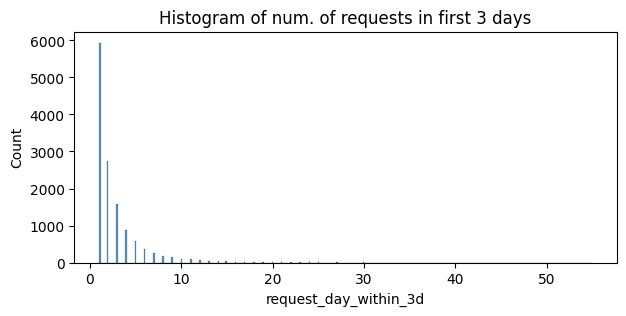

In [ ]:
# Show histogram of the number of requests in the first 3 days
plt.figure(figsize=(7,3))
sns.histplot(num_req_within_3d, x="request_day_within_3d")

plt.title('Histogram of num. of requests in first 3 days')
plt.show()

In [ ]:
# function categorizes the number of property interactions (x) into three different groups
def divide(x):
    if x in [1,2]:
        return 'cat_1_to_2'
    elif x in [3,4,5]:
        return 'cat_3_to_5'
    else:
        return 'cat_above_5'


In [ ]:
# this column groups the number of interactions a property received within 3 days into three categories
num_req_within_3d['categories_3day'] = num_req_within_3d['request_day_within_3d'].apply(divide)
num_req_within_3d.head(3)

,property_id,request_day_within_3d,categories_3day
0,ff808081469fd6e20146a5af948000ea,4,cat_3_to_5
1,ff8080814702d3d10147068359d200cd,3,cat_3_to_5
2,ff808081470c645401470fb03f5800a6,15,cat_above_5


In [ ]:
num_req_within_3d['categories_3day'].value_counts()

,count
categories_3day,
cat_1_to_2,8681
cat_3_to_5,3049
cat_above_5,1480


By the end of this step, we have the `categories_3day` column that has the three classes:

* `cat_1_to_2` appears 8681 times
* `cat_3_to_5` appears 3049 times
* `cat_above_5` appears 1480 times

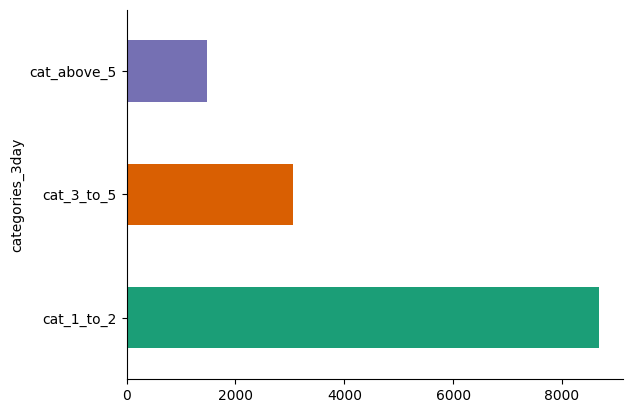

In [ ]:
# 3day categories
num_req_within_3d.groupby('categories_3day').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

##Number of Interaction Within 7 Days
In this step, like before, we will get the number of interactions but this time within 7 days by following steps:

First, by taking the dataset we used before which has `[property_id, request_date, activation_date]` columns
Second, we get a count of requests within the first 7 days, by taking all values if the Time between the Request and Activation Date is less than 7

In [ ]:
# Get a count of requests in the first 7 days
num_req_within_7d = num_req[num_req['request_day'] < 7].groupby('property_id').agg({ 'request_day':'count'}).reset_index()
# Show every property id with the number of requests in the first 7 days
num_req_within_7d = num_req_within_7d.rename({'request_day':'request_day_within_7d'},axis=1)
# Dataset with the number of requests within 7 days
num_req_within_7d

,property_id,request_day_within_7d
0,ff808081469fd6e20146a5af948000ea,4
1,ff8080814702d3d10147068359d200cd,5
2,ff808081470c645401470fb03f5800a6,22
3,ff808081470c6454014715eaa5960281,7
4,ff808081474aa867014771a0298f0aa6,52
...,...,...
17381,ff8081815b1fdda8015b1fe675ae0146,8
17382,ff8081815b1fdda8015b1ffee8a305d2,3
17383,ff8081815b1fdda8015b2000369205fd,2
17384,ff8081815b200540015b20158b0103c9,2


We can convert the Interaction values to categorical values. After seeing the distribution of interactions within 3 days, we decide to convert the values into three classes:

* `cat_1_to_2`: one or two requests within 7 days
* `cat_3_to_5` : three to five requests within 7 days
* `cat_above_5` : above five requests within 7 days

In [ ]:
num_req_within_7d['request_day_within_7d'].value_counts()[:10]

,count
request_day_within_7d,
1,5856
2,3381
3,2118
4,1421
5,1047
6,735
7,597
8,373
9,323


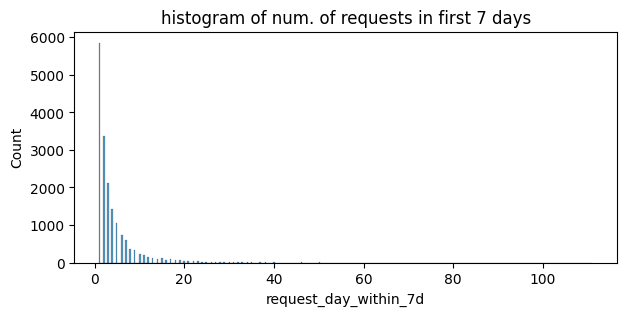

In [ ]:
# Show histogram of the number of requests in the first 3 days
plt.figure(figsize=(7,3))
sns.histplot(num_req_within_7d, x="request_day_within_7d")

plt.title('histogram of num. of requests in first 7 days')
plt.show()

In [ ]:
num_req_within_7d['categories_7day'] = num_req_within_7d['request_day_within_7d'].apply(divide)
num_req_within_7d.head(3)

,property_id,request_day_within_7d,categories_7day
0,ff808081469fd6e20146a5af948000ea,4,cat_3_to_5
1,ff8080814702d3d10147068359d200cd,5,cat_3_to_5
2,ff808081470c645401470fb03f5800a6,22,cat_above_5


In [ ]:
num_req_within_7d['categories_7day'].value_counts()

,count
categories_7day,
cat_1_to_2,9237
cat_3_to_5,4586
cat_above_5,3563


By the end of this step, we have the categories_7day column that has the three classes:

* `cat_1_to_2` appears 9237 times
* `cat_3_to_5` appears 4586 times
* `cat_above_5` appears 3563 times

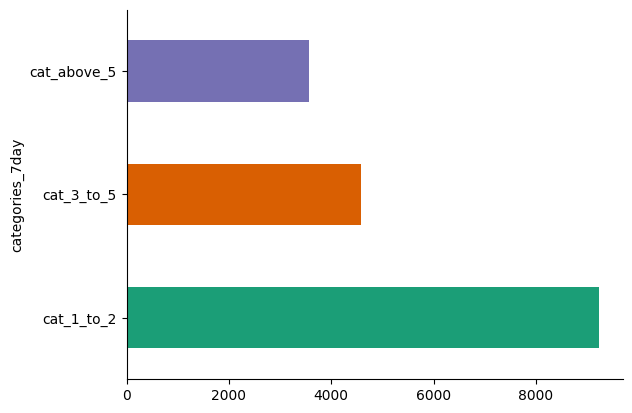

In [ ]:
# 7 day categories
num_req_within_7d.groupby('categories_7day').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

##Merge Data
All these data are merged here to create a dataset containing all the features and labels that were created.

In [ ]:
pics.sample()

,property_id,photo_count
7503,ff80818158e8f4560158ecea31176240,1


In [ ]:
num_req_within_3d.sample()

,property_id,request_day_within_3d,categories_3day
604,ff8081814f3a5c3d014f3b5715880cb7,2,cat_1_to_2


In [ ]:
num_req_within_7d.sample()

,property_id,request_day_within_7d,categories_7day
9021,ff8081815a4c18d8015a4f7d30fa07b6,2,cat_1_to_2


In [ ]:
print(num_req_within_3d.shape)
print(num_req_within_7d.shape)

(13210, 3)
(17386, 3)


In [ ]:
label_data = pd.merge(num_req_within_7d, num_req_within_3d, on ='property_id' , how='left')
# label_data['request_day_within_3d'] = label_data['request_day_within_3d'].fillna(0)
label_data.head(3)

,property_id,request_day_within_7d,categories_7day,request_day_within_3d,categories_3day
0,ff808081469fd6e20146a5af948000ea,4,cat_3_to_5,4.0,cat_3_to_5
1,ff8080814702d3d10147068359d200cd,5,cat_3_to_5,3.0,cat_3_to_5
2,ff808081470c645401470fb03f5800a6,22,cat_above_5,15.0,cat_above_5


In [ ]:
# counts missing values in column
label_data.isna().sum()

,0
property_id,0
request_day_within_7d,0
categories_7day,0
request_day_within_3d,4176
categories_3day,4176


In [ ]:
# merging data & images
data_with_pics = pd.merge(data, pics, on ='property_id', how = 'left')
data_with_pics.head(3)

,property_id,type,activation_date,bathroom,floor,total_floor,furnishing,gym,latitude,longitude,lease_type,lift,locality,parking,property_age,property_size,swimming_pool,pin_code,rent,deposit,building_type,photo_count
0,ff808081469fd6e20146a5af948000ea,BHK2,09-03-2017 14:36,1,3,4.0,SEMI_FURNISHED,1,12.876174,77.596571,FAMILY,1,Hulimavu,BOTH,2,850,1,560076.0,12000,120000,AP,7
1,ff8080814702d3d10147068359d200cd,BHK2,07-03-2017 12:02,2,4,11.0,SEMI_FURNISHED,1,13.018444,77.678122,FAMILY,1,Ramamurthy Nagar,BOTH,1,1233,1,560016.0,20000,150000,AP,0
2,ff808081470c645401470fb03f5800a6,BHK2,10-03-2017 13:43,2,0,4.0,NOT_FURNISHED,1,12.975072,77.665865,ANYONE,1,GM Palya,FOUR_WHEELER,0,1200,0,560075.0,15000,75000,AP,12


In [ ]:
# merging data with images dataset with label data
dataset = pd.merge(data_with_pics, label_data, on ='property_id')
dataset.head(3)

,property_id,type,activation_date,bathroom,floor,total_floor,furnishing,gym,latitude,longitude,lease_type,lift,locality,parking,property_age,property_size,swimming_pool,pin_code,rent,deposit,building_type,photo_count,request_day_within_7d,categories_7day,request_day_within_3d,categories_3day
0,ff808081469fd6e20146a5af948000ea,BHK2,09-03-2017 14:36,1,3,4.0,SEMI_FURNISHED,1,12.876174,77.596571,FAMILY,1,Hulimavu,BOTH,2,850,1,560076.0,12000,120000,AP,7,4,cat_3_to_5,4.0,cat_3_to_5
1,ff8080814702d3d10147068359d200cd,BHK2,07-03-2017 12:02,2,4,11.0,SEMI_FURNISHED,1,13.018444,77.678122,FAMILY,1,Ramamurthy Nagar,BOTH,1,1233,1,560016.0,20000,150000,AP,0,5,cat_3_to_5,3.0,cat_3_to_5
2,ff808081470c645401470fb03f5800a6,BHK2,10-03-2017 13:43,2,0,4.0,NOT_FURNISHED,1,12.975072,77.665865,ANYONE,1,GM Palya,FOUR_WHEELER,0,1200,0,560075.0,15000,75000,AP,12,22,cat_above_5,15.0,cat_above_5


In [ ]:
dataset.isna().sum()

,0
property_id,0
type,0
activation_date,0
bathroom,0
floor,0
...,...
photo_count,0
request_day_within_7d,0
categories_7day,0
request_day_within_3d,4176


##Exploratory Data Analysis and Processing

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17386 entries, 0 to 17385
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   property_id            17386 non-null  object 
 1   type                   17386 non-null  object 
 2   activation_date        17386 non-null  object 
 3   bathroom               17386 non-null  int64  
 4   floor                  17386 non-null  int64  
 5   total_floor            17363 non-null  float64
 6   furnishing             17386 non-null  object 
 7   gym                    17386 non-null  int64  
 8   latitude               17386 non-null  float64
 9   longitude              17386 non-null  float64
 10  lease_type             17386 non-null  object 
 11  lift                   17386 non-null  int64  
 12  locality               17386 non-null  object 
 13  parking                17386 non-null  object 
 14  property_age           17386 non-null  int64  
 15  pr

In [ ]:
# Some info about all columns
print('Column Name\tData Type\tNull Value Count')
print('---------------------------------------------')
for col in dataset.columns:
    print(f"{col:<15}\t{str(dataset[col].dtype):<10}\t{dataset[col].isna().sum()}")

Column Name	Data Type	Null Value Count
---------------------------------------------
property_id    	object    	0
type           	object    	0
activation_date	object    	0
bathroom       	int64     	0
floor          	int64     	0
total_floor    	float64   	23
furnishing     	object    	0
gym            	int64     	0
latitude       	float64   	0
longitude      	float64   	0
lease_type     	object    	0
lift           	int64     	0
locality       	object    	0
parking        	object    	0
property_age   	int64     	0
property_size  	int64     	0
swimming_pool  	int64     	0
pin_code       	float64   	162
rent           	int64     	0
deposit        	int64     	0
building_type  	object    	38
photo_count    	int64     	0
request_day_within_7d	int64     	0
categories_7day	object    	0
request_day_within_3d	float64   	4176
categories_3day	object    	4176


In [ ]:
# Some info about all columns
print('Column : Num. of null values')
print(dict(dataset.isna().sum()))
print('\n\n')
print('Column : data type')
print(dict(dataset.dtypes))

Column : Num. of null values
{'property_id': 0, 'type': 0, 'activation_date': 0, 'bathroom': 0, 'floor': 0, 'total_floor': 23, 'furnishing': 0, 'gym': 0, 'latitude': 0, 'longitude': 0, 'lease_type': 0, 'lift': 0, 'locality': 0, 'parking': 0, 'property_age': 0, 'property_size': 0, 'swimming_pool': 0, 'pin_code': 162, 'rent': 0, 'deposit': 0, 'building_type': 38, 'photo_count': 0, 'request_day_within_7d': 0, 'categories_7day': 0, 'request_day_within_3d': 4176, 'categories_3day': 4176}



Column : data type
{'property_id': dtype('O'), 'type': dtype('O'), 'activation_date': dtype('O'), 'bathroom': dtype('int64'), 'floor': dtype('int64'), 'total_floor': dtype('float64'), 'furnishing': dtype('O'), 'gym': dtype('int64'), 'latitude': dtype('float64'), 'longitude': dtype('float64'), 'lease_type': dtype('O'), 'lift': dtype('int64'), 'locality': dtype('O'), 'parking': dtype('O'), 'property_age': dtype('int64'), 'property_size': dtype('int64'), 'swimming_pool': dtype('int64'), 'pin_code': dtype('f

After seeing this information about the data, we can handle null values in columns `[total_floor, building_type]` in the following steps. The null values in columns `[request_day_within_3d, categories_3day]` are normal because there are more requests within 7 days than requests within 3 days and we will handle these nulls in the modeling part. The data type is correct for every column.

In [ ]:
dataset['locality'].value_counts()

,count
locality,
Whitefield,517
JP Nagar,415
Marathahalli,414
HSR Layout,380
Electronic City,341
...,...
Kereguddadahalli,1
Benson town,1
Block 1st Koramangala,1


We will drop the column `property_id` because it wouldn't help in models, also `activation_date, latitude, longitude, pin_code, locality` wouldn't help in the model

In [ ]:
# Droppping columns without any influence on the number of requests
dataset = dataset.drop(['property_id', 'activation_date' ,'latitude', 'longitude', 'pin_code','locality'  ] , axis=1)

We'll observe the histogram of target columns: `request_day_within_7d, categories_7day, request_day_within_3d, categories_3day`

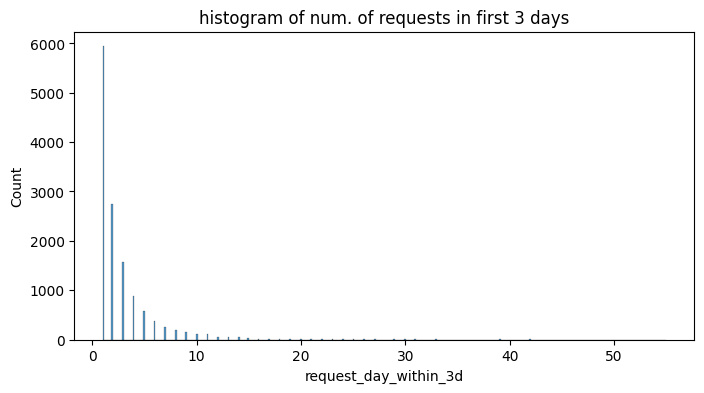

In [ ]:
# Show histogram of the number of requests in first 3 days
plt.figure(figsize=(8,4))
sns.histplot(dataset, x="request_day_within_3d")

plt.title('histogram of num. of requests in first 3 days')
plt.show()

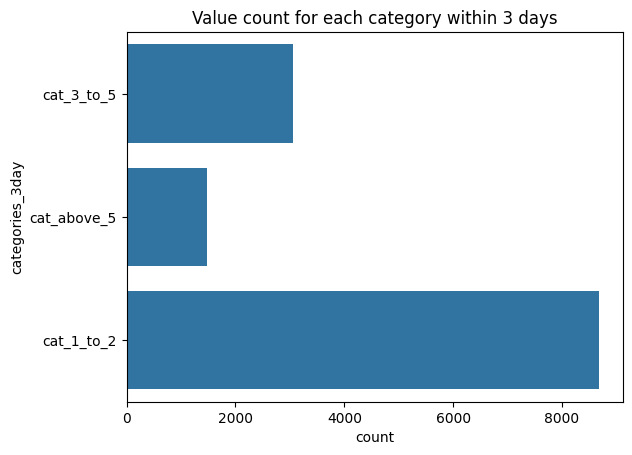

In [ ]:
sns.countplot(y=dataset.categories_3day)
plt.title('Value count for each category within 3 days')
plt.show()

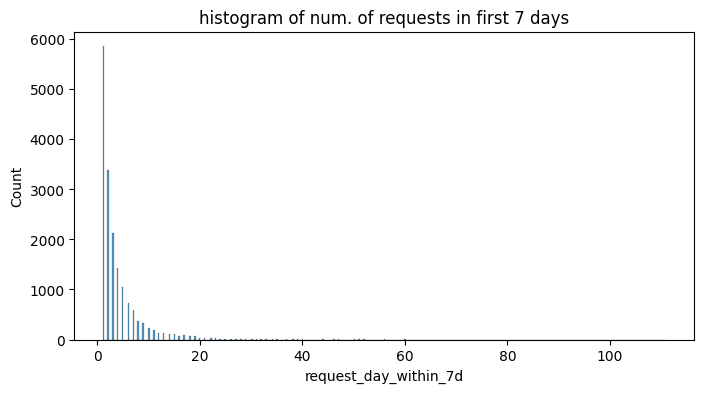

In [ ]:
# Show histogram of the number of requests in first 3 days
plt.figure(figsize=(8,4))
sns.histplot(dataset, x="request_day_within_7d")

plt.title('histogram of num. of requests in first 7 days')
plt.show()

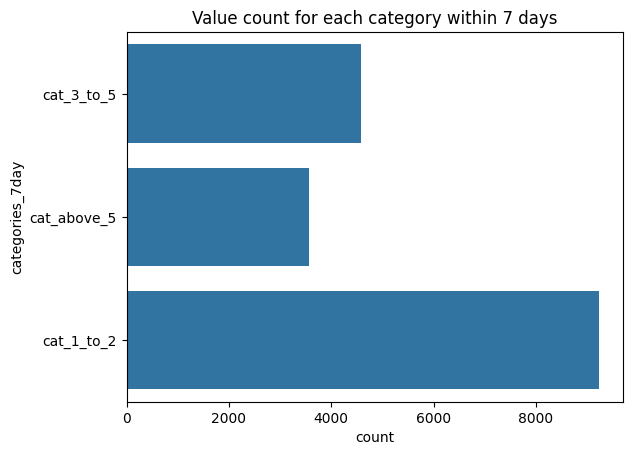

In [ ]:
sns.countplot(y=dataset.categories_7day)
plt.title('Value count for each category within 7 days')
plt.show()

In the following steps, we'll divide data into categorical and numeric columns to analyze both of them separately.

In [ ]:
# Get categorical columns
df_cat = dataset.select_dtypes(include=['object'])
# Get numeric columns
df_num = dataset.select_dtypes(exclude=['object'])

In [ ]:
print("Categorical Columns : \n",list(df_cat.columns) )
print("Numeric Columns : \n",list(df_num.columns) )

Categorical Columns : 
 ['type', 'furnishing', 'lease_type', 'parking', 'building_type', 'categories_7day', 'categories_3day']
Numeric Columns : 
 ['bathroom', 'floor', 'total_floor', 'gym', 'lift', 'property_age', 'property_size', 'swimming_pool', 'rent', 'deposit', 'photo_count', 'request_day_within_7d', 'request_day_within_3d']


In [ ]:
df_num.sample(2)

,bathroom,floor,total_floor,gym,lift,property_age,property_size,swimming_pool,rent,deposit,photo_count,request_day_within_7d,request_day_within_3d
16405,1,0,1.0,0,0,0,350,0,5500,1,0,2,1.0
6515,1,3,3.0,0,0,2,700,0,11000,110000,1,1,NaN


First, we'll show the value and count of it in every categorical column. Then we show it as a bar chart.

* **BHK1**: 1 bedroom, a hall, and a kitchen.
* **BHK2**: 2 bedrooms, a hall, and a kitchen.
* **BHK3**: 3 bedrooms, a hall, and a kitchen.
* **BHK4**: 4 bedrooms, a hall, and a kitchen.
* **RK1**: "Room Kitchen", typically studio smaller than BHK1 .


In [ ]:
# Show all values and get count of them in every categorical column
for col in df_cat.columns[:-2]: # excludes the target variable columns categories_7day and categories_3day.
    print('Column Name : ', col)
    print(df_cat[col].value_counts())
    print('\n-------------------------------------------------------------\n')

Column Name :  type
type
BHK2        8510
BHK1        4508
BHK3        2691
RK1         1497
BHK4         157
BHK4PLUS      23
Name: count, dtype: int64

-------------------------------------------------------------

Column Name :  furnishing
furnishing
SEMI_FURNISHED     13523
NOT_FURNISHED       2917
FULLY_FURNISHED      946
Name: count, dtype: int64

-------------------------------------------------------------

Column Name :  lease_type
lease_type
FAMILY      8401
ANYONE      8026
BACHELOR     928
COMPANY       31
Name: count, dtype: int64

-------------------------------------------------------------

Column Name :  parking
parking
TWO_WHEELER     8059
BOTH            7771
NONE             921
FOUR_WHEELER     635
Name: count, dtype: int64

-------------------------------------------------------------

Column Name :  building_type
building_type
IF    10171
AP     6000
IH     1177
Name: count, dtype: int64

-------------------------------------------------------------



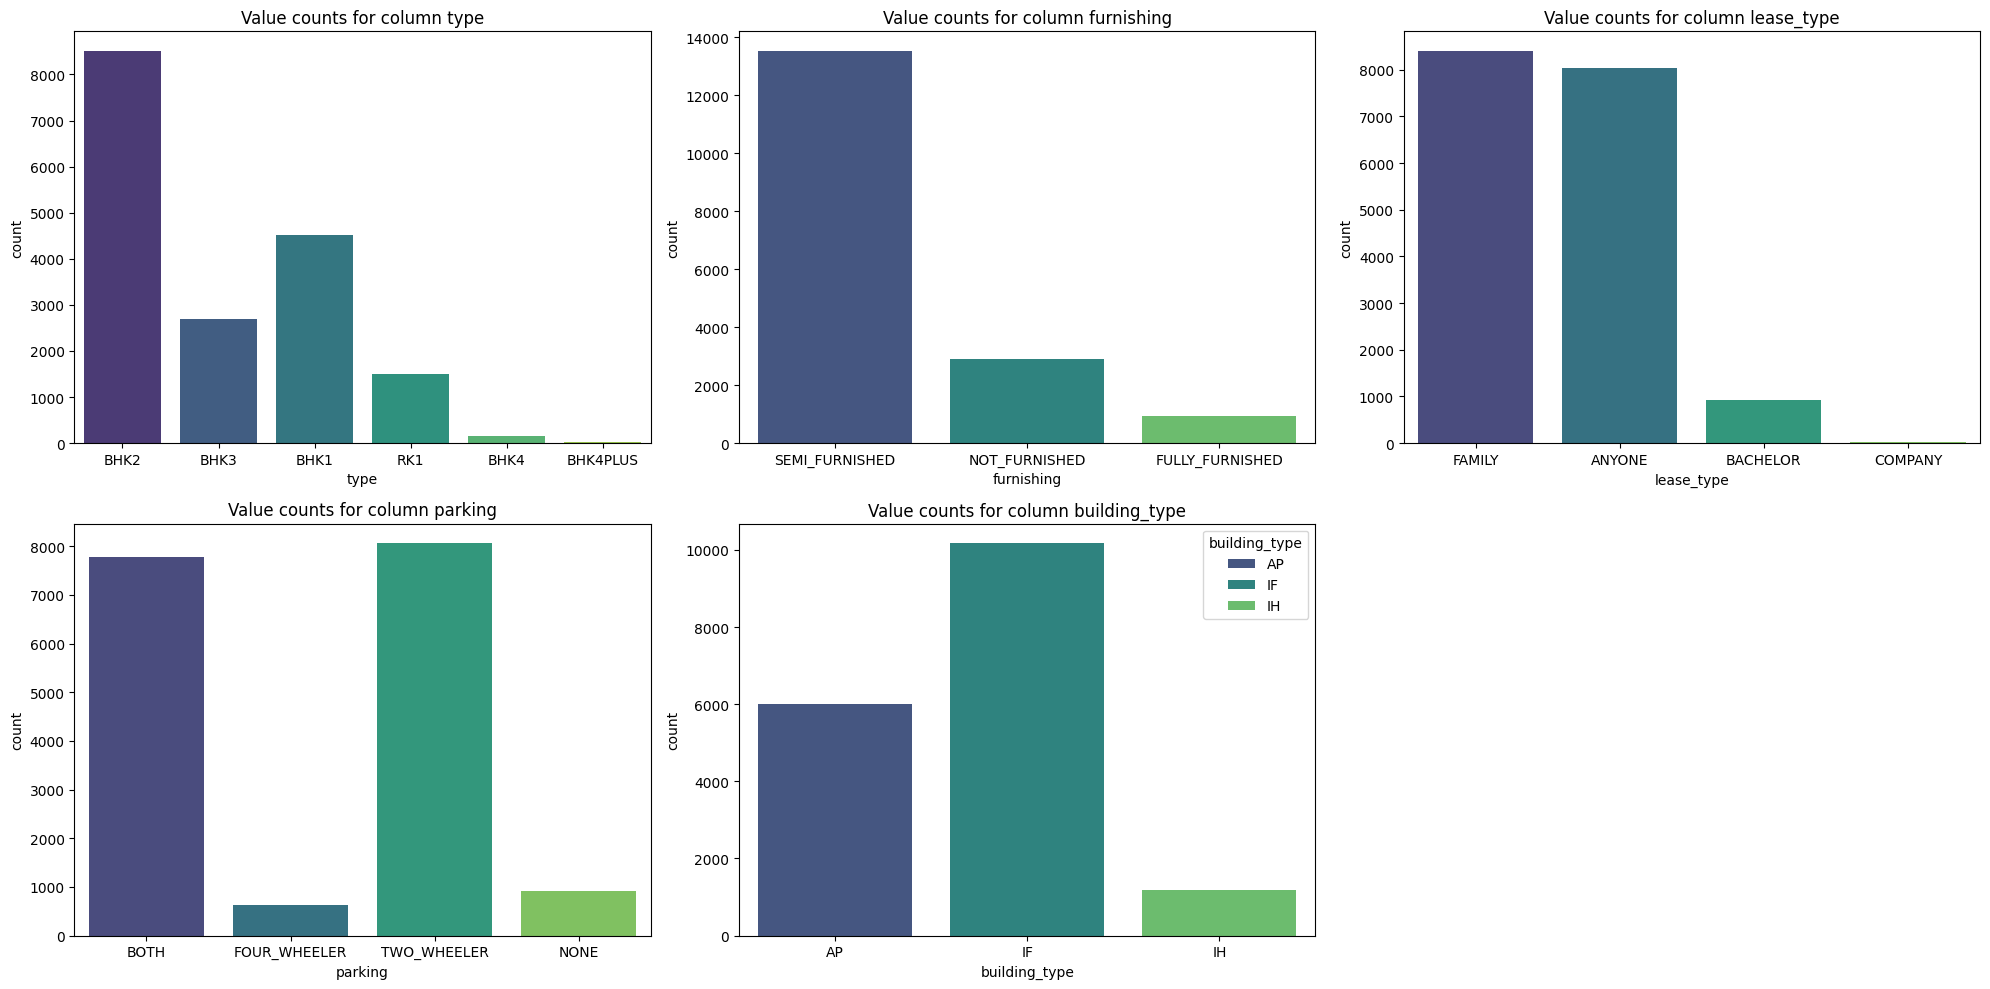

In [ ]:
import math

# Calculate the number of plots needed
num_plots = len(df_cat.columns[:-2])

# Calculate rows and columns for subplots
num_cols = 3  # Fixed number of columns
num_rows = math.ceil(num_plots / num_cols)  # Calculate rows dynamically

# Create a figure and an array of subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 5))  # Adjust figsize

# Flatten the axes array for easier iteration
axes = axes.flatten()

palette = ['']

# Iterate through columns and create count plots on subplots
for i, col in enumerate(df_cat.columns[:-2]):
    sns.countplot(x=col, data=dataset, ax=axes[i], hue=col, palette='viridis')
    axes[i].set_title(f'Value counts for column {col}')

# Hide empty subplots (if any)
for i in range(num_plots, num_rows * num_cols):
    axes[i].set_visible(False)

# Show the plot
plt.tight_layout()
plt.show()

Now we can see in columns:

* `type`: *BHK4PLUS* has minimum count and *BHK2* maximum count
* `furnishing`: *FULLY_FURNISHED* has minimum count and *SEMI_FURNISHED* maximum count
* `lease_type`: *COMPANY* has minimum count and *FAMILY* maximum count
* `parking`: *FOUR_WHEELER* has minimum count and *TWO_WHEELER* maximum count
* `building_type`: *IH* has minimum count and *IF* maximum count

Then let's take a look at numeric data.

In [ ]:
df_num.head()

,bathroom,floor,total_floor,gym,lift,property_age,property_size,swimming_pool,rent,deposit,photo_count,request_day_within_7d,request_day_within_3d
0,1,3,4.0,1,1,2,850,1,12000,120000,7,4,4.0
1,2,4,11.0,1,1,1,1233,1,20000,150000,0,5,3.0
2,2,0,4.0,1,1,0,1200,0,15000,75000,12,22,15.0
3,2,3,4.0,0,0,1,1300,0,17000,150000,9,7,5.0
4,1,1,2.0,0,0,4,450,0,6500,40000,7,52,25.0


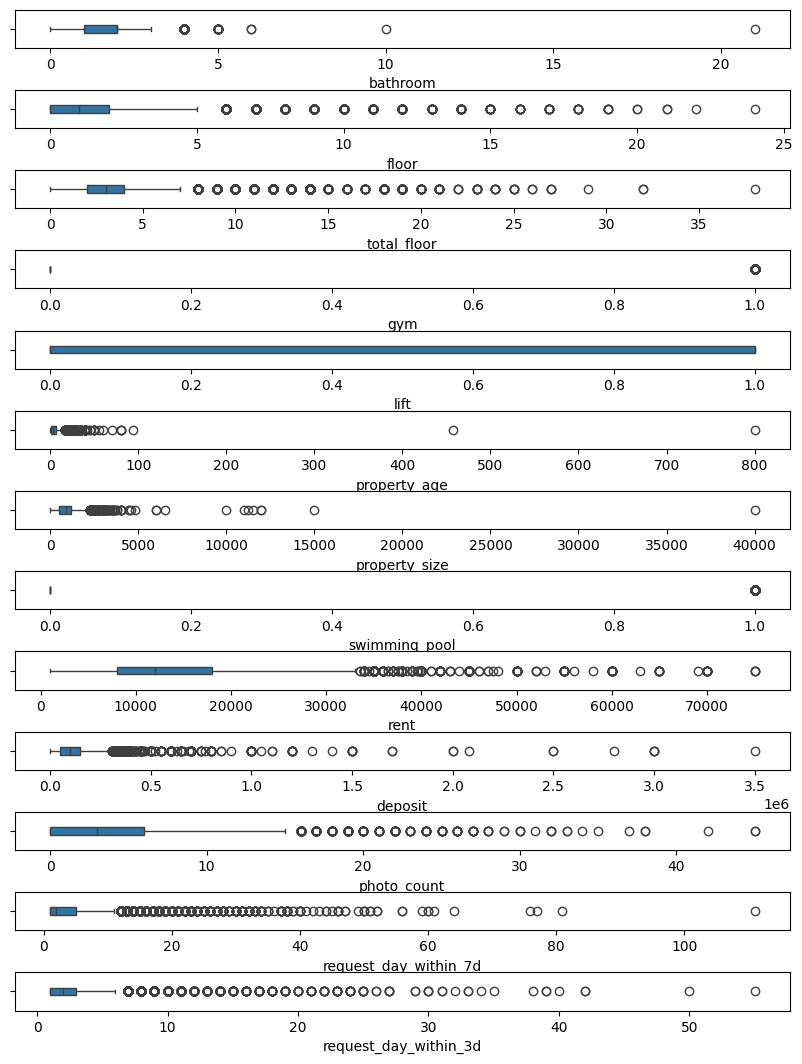

In [ ]:
## Shows ranges of values and outliers
# Get numeric columns
numeric_cols = df_num.select_dtypes(include=['number']).columns

# Calculate number of rows and columns for subplots
num_cols = 1  # One column for vertical arrangement
num_rows = len(numeric_cols)

# Create subplots with adjusted figsize
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, num_rows * 1))  # Reduced figsize height

# Iterate through columns and create horizontal box plots with reduced width
for i, column in enumerate(numeric_cols):
    sns.boxplot(x=df_num[column], ax=axes[i], orient='h', width=0.2)  # Reduced width

plt.subplots_adjust(hspace=1.1)  # Adjust hspace for vertical spacing
plt.show()

In [ ]:
# Get some statistics about numeric columns
df_num.describe()

,bathroom,floor,total_floor,gym,lift,property_age,property_size,swimming_pool,rent,deposit,photo_count,request_day_within_7d,request_day_within_3d
count,17386.000000,17386.000000,17363.000000,17386.000000,17386.000000,17386.000000,17386.000000,17386.000000,17386.000000,1.738600e+04,17386.000000,17386.000000,13210.000000
mean,1.702692,1.726101,3.382077,0.150063,0.265156,4.789141,912.091510,0.126769,13822.809847,1.145386e+05,3.803635,4.013632,2.802801
std,0.716630,2.041864,3.040158,0.357144,0.441429,8.781275,608.803608,0.332723,8272.442456,1.167101e+05,4.231098,5.050688,3.187711
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1000.000000,0.000000e+00,0.000000,1.000000,1.000000
25%,1.000000,0.000000,2.000000,0.000000,0.000000,1.000000,507.000000,0.000000,8000.000000,5.000000e+04,0.000000,1.000000,1.000000
50%,2.000000,1.000000,3.000000,0.000000,0.000000,3.000000,875.000000,0.000000,12000.000000,1.000000e+05,3.000000,2.000000,2.000000
75%,2.000000,2.000000,4.000000,0.000000,1.000000,7.000000,1200.000000,0.000000,18000.000000,1.500000e+05,6.000000,5.000000,3.000000
max,21.000000,24.000000,38.000000,1.000000,1.000000,800.000000,40000.000000,1.000000,75000.000000,3.500000e+06,45.000000,111.000000,55.000000


Creating this pair plot is to visually explore if there are any correlations or patterns between property features (age, size, rent, etc.) and the number of interactions it receives within the first 3 days

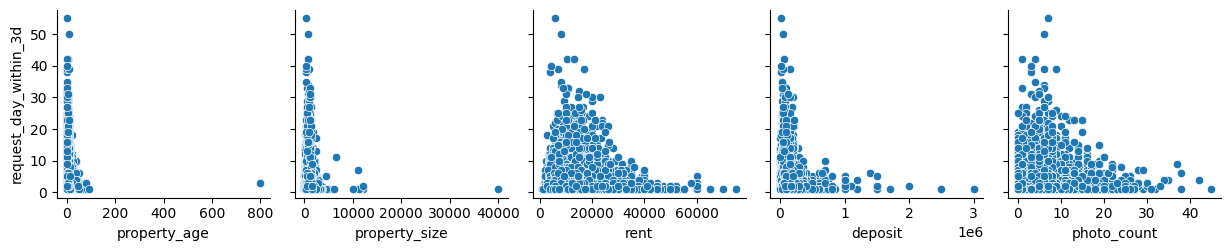

In [ ]:
# shows correlation between predictors and target - requests within 3 days
sns.pairplot(data=dataset,
                  x_vars=['property_age', 'property_size','rent', 'deposit', 'photo_count'],
                  y_vars=['request_day_within_3d']

                  )
plt.show()

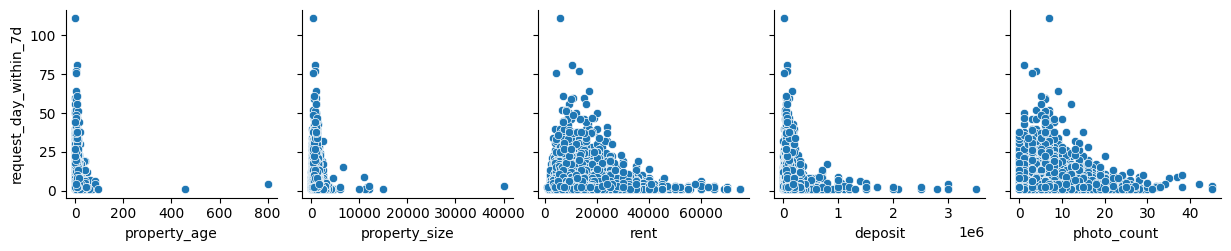

In [ ]:
# shows correlation between predictors and target - requests within 7 days
sns.pairplot(data=dataset,
                  x_vars=['property_age', 'property_size','rent', 'deposit', 'photo_count'],
                  y_vars=['request_day_within_7d']

                  )
plt.show()

After exploring the data, we can find there are many outlier values that need to be handled.

##Feature Engineering
In this section, we will apply some changes in the data to make it ready for the Modeling part, such as:

* Removing outliers using the IQR method
* Encoding categorical data
* Using the MinMaxScaler to scale numeric data

###Remove Outliers
Remove Outliers from numeric data using the Interquartile Range (IQR) method.

The Interquartile Range (IQR) method uses the 25th and 75th percentiles (quartiles) to identify outliers in a dataset. Outliers are defined as observations that fall below the 25th percentile minus 1.5 times the IQR or above the 75th percentile plus 1.5 times the IQR. This method is useful as it considers the variability within the data, rather than using fixed threshold values.

In [ ]:
# Function to remove outliers using quantiles
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3 - q1 #Interquartile range
    lower_bound  = q1 - 2 * iqr
    upper_bound = q3 + 2 * iqr
    df_out = df_in.loc[(df_in[col_name] <= upper_bound) & (df_in[col_name] >= lower_bound)] # selects specific rows based on a condition
    return df_out

In [ ]:
df_num.columns

Index(['bathroom', 'floor', 'total_floor', 'gym', 'lift', 'property_age',
       'property_size', 'swimming_pool', 'rent', 'deposit', 'photo_count',
       'request_day_within_7d', 'request_day_within_3d'],
      dtype='object')

We apply the outlier function on all numeric columns except the target columns `request_day_within_3d`, `request_day_within_7d` and binary columns like `gym`, `lift`, `swimming_pool`

In [ ]:
df = dataset.copy()
# loop iterates through each col in df_num.columns
for col in df_num.columns:
    # exluded columns, that are binary or target
    if col in ['gym', 'lift', 'swimming_pool',  'request_day_within_3d', 'request_day_within_7d']:
        continue
    # passes the dataframe df and the column name col as arguments, removes outliers using IQR method within.
    df = remove_outlier(df , col)

In [ ]:
# Function takes a number as input. If that number is greater than 10, it returns 10.
# Otherwise, it returns the original number. This prevents values from exceeding 10.
def capping_for_3days(x):
    num = 10
    if x > num: # checks if threshold value > 10
        return num # if yes, returns threshold value num
    else :
        return x # if not, it moved back to x
def capping_for_7days(x):
    num = 20
    if x > num:
        return num
    else :
        return x

In [ ]:
df['request_day_within_3d_capping'] = df['request_day_within_3d'].apply(capping_for_3days)
df['request_day_within_7d_capping'] = df['request_day_within_7d'].apply(capping_for_7days)

In [ ]:
df['request_day_within_3d_capping'].value_counts()

,count
request_day_within_3d_capping,
1.0,5115
2.0,2403
3.0,1404
4.0,795
5.0,532
10.0,495
6.0,339
7.0,228
8.0,168


In [ ]:
df['request_day_within_7d_capping'].value_counts()[:10]

,count
request_day_within_7d_capping,
1,4934
2,2923
3,1848
4,1264
5,937
6,663
7,549
8,330
20,319


Let's use Capping for outliers in target columns. Capping refers to replacing the outliers with a near value so that we can keep the point in our analysis while avoiding skewing the data.

Why Capping is Used:

* Outlier Handling: Outliers can significantly distort the results of machine learning models. Capping helps to mitigate their impact.
* Model Stability: It can lead to more stable and robust models, especially for algorithms sensitive to extreme values.
* Improved Performance: By reducing the influence of outliers, capping can potentially improve the predictive accuracy of the models.

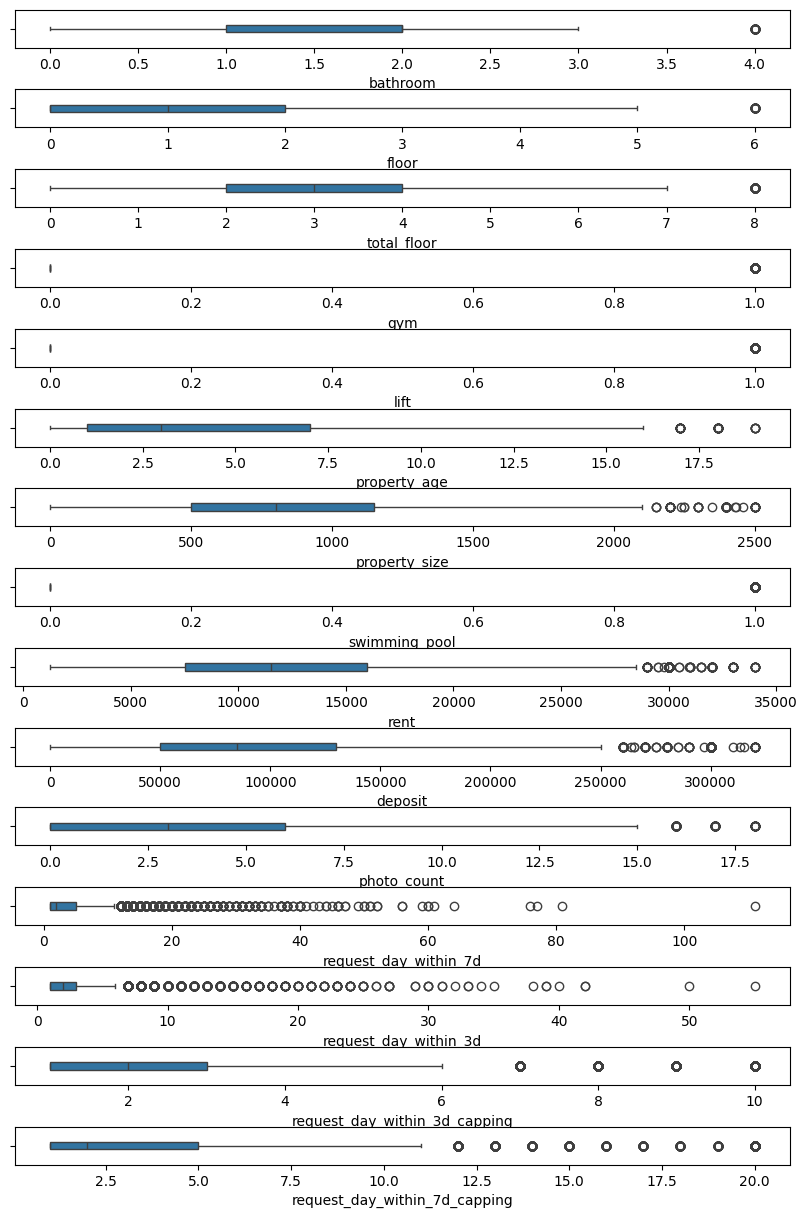

In [ ]:
## Box plot after removing some values
# Get numeric columns
numeric_cols = df.select_dtypes(include=['number']).columns

# Calculate number of rows and columns for subplots
num_cols = 1  # One column for vertical arrangement
num_rows = len(numeric_cols)

# Create subplots with adjusted figsize
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, num_rows * 1))  # Reduced figsize height

# Iterate through columns and create horizontal box plots with reduced width
for i, column in enumerate(numeric_cols):
    sns.boxplot(x=df[column], ax=axes[i], orient='h', width=0.2)  # Reduced width

plt.subplots_adjust(hspace=1.1)  # Adjust hspace for vertical spacing
plt.show()

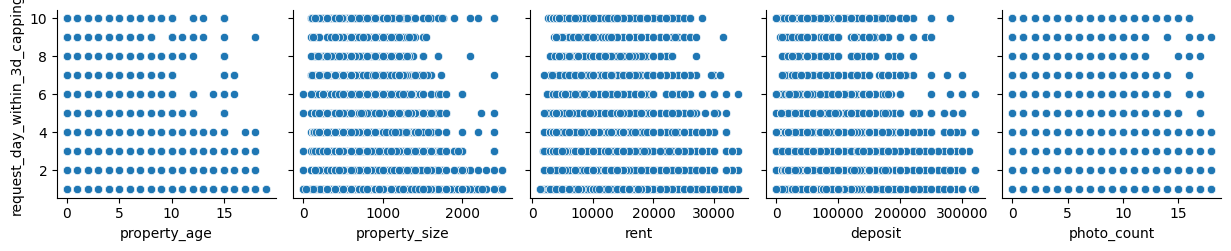

In [ ]:
sns.pairplot(data=df,
                  x_vars=['property_age', 'property_size','rent', 'deposit', 'photo_count'],
                  y_vars=['request_day_within_3d_capping']
                  )
plt.show()

The purpose is to explore if there are any correlations or patterns between property features and the number of interactions it receives within the first 3 days. There is no correlation.


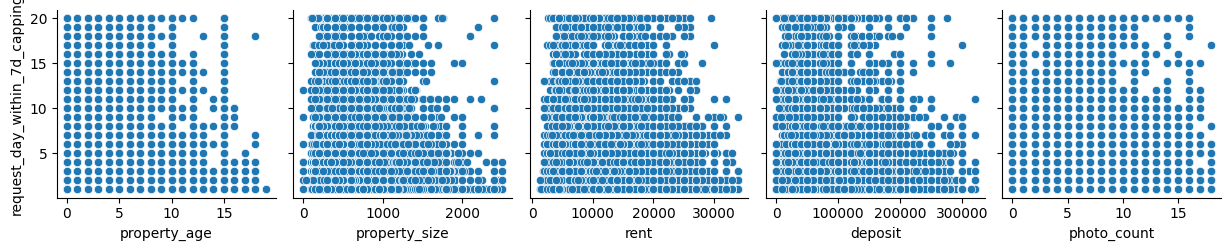

In [ ]:
sns.pairplot(data=df,
                  x_vars=['property_age', 'property_size','rent', 'deposit', 'photo_count'],
                  y_vars=['request_day_within_7d_capping']

                  )
plt.show()

There is no descirnible pattern in number of interactions received within first 7 days neither.

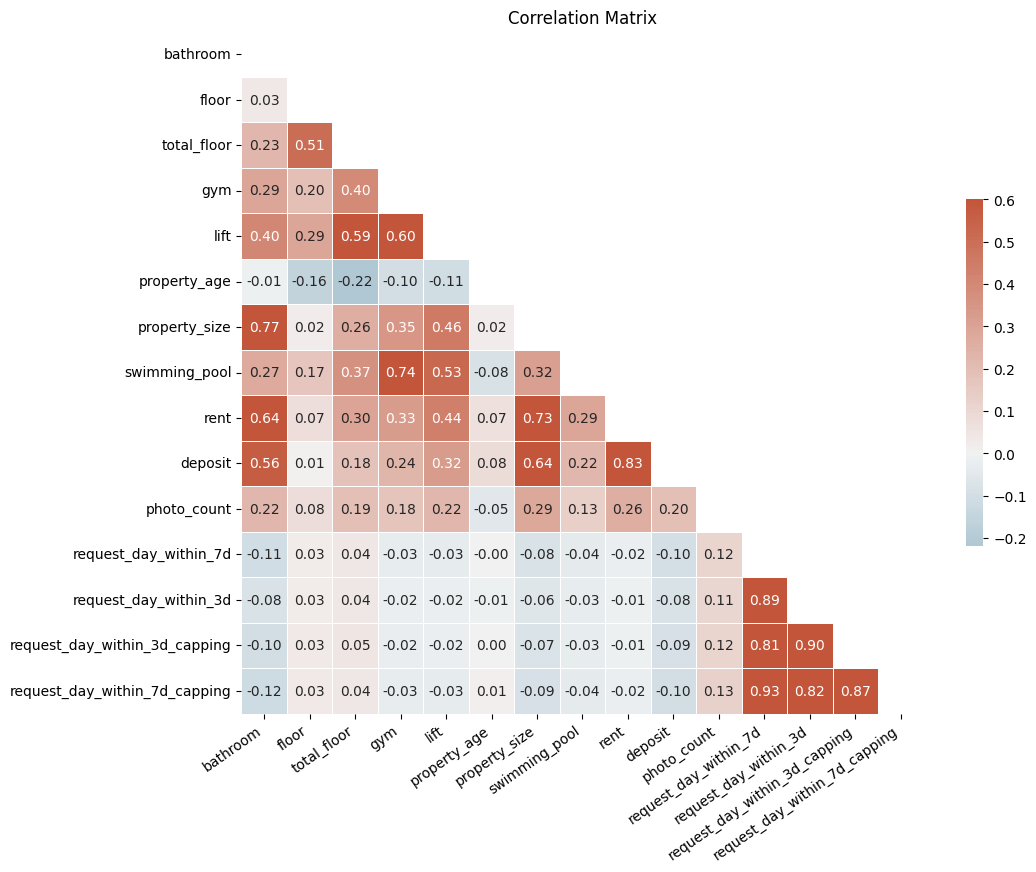

In [ ]:
# Select only numeric features for correlation calculation
numeric_df = df.select_dtypes(include=['number'])

# Calculate the correlation matrix
corr = numeric_df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

cmap=sns.diverging_palette(230, 20, as_cmap=True)

#cmap="YlGnBu"

# Create the heatmap
plt.figure(figsize=(11, 9))
dataplot = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.6, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},
                       annot=True, fmt=".2f")

plt.xticks(rotation=35, ha='right')
plt.title('Correlation Matrix')

# Display the heatmap
plt.show()

##One-Hot Encoding
We'll use the One-Hot Encoding method to convert categorical values to numeric so that we are able to use this data as input for the model.

One hot encoding is one method of converting data to prepare it for an algorithm and get a better prediction. With one-hot, we convert each categorical value into a new categorical column and assign a binary value of 1 or 0 to those columns. Each integer value is represented as a binary vector. All the values are zero, and the index is marked with a 1.

In [ ]:
df.columns

Index(['type', 'bathroom', 'floor', 'total_floor', 'furnishing', 'gym',
       'lease_type', 'lift', 'parking', 'property_age', 'property_size',
       'swimming_pool', 'rent', 'deposit', 'building_type', 'photo_count',
       'request_day_within_7d', 'categories_7day', 'request_day_within_3d',
       'categories_3day', 'request_day_within_3d_capping',
       'request_day_within_7d_capping'],
      dtype='object')

In [ ]:
# One-Hot Encoder for categorical values
# dividing data to categorical, numeric and label
X = df.drop(['request_day_within_7d', 'categories_7day', 'request_day_within_3d',
             'categories_3day', 'request_day_within_3d_capping',
             'request_day_within_7d_capping'] , axis=1)
x_cat_withNull= df[X.select_dtypes(include=['O']).columns]
x_remain_withNull = df[X.select_dtypes(exclude=['O']).columns]
y = df[['request_day_within_7d', 'categories_7day', 'request_day_within_3d',
             'categories_3day', 'request_day_within_3d_capping',
             'request_day_within_7d_capping']]

In [ ]:
x_remain = pd.DataFrame()
x_cat = pd.DataFrame()

Before running OHE, first, we will handle the Null values by using the imputation method (fill null value in numeric columns with mean value, and fill null value in categorical columns with mode).

Imputation methods are those where the missing data are filled in to create a complete data matrix that can be analyzed using standard methods.

Reasoning:

1. **Simplicity and Efficiency**: Mean/Mode imputation is a straightforward and computationally inexpensive method. It's a good starting point, especially when dealing with a relatively small number of missing values.

2. **Minimal Data Distortion**: For numeric features like total_floor and building_type, using the mean is likely to have a minimal impact on the overall data distribution, especially if the data is normally distributed or the missing values are randomly scattered. Replacing with the mean preserves the central tendency of the data without introducing significant bias.

3. **Maintaining Categorical Integrity**: For categorical columns like building_type, using the mode (most frequent category) ensures that you're using an existing category to fill the gaps. It preserves the categorical nature of the data and avoids introducing any unknown or potentially invalid categories.

4. **Dataset Characteristics**: The user likely chose this method based on the observed characteristics of their dataset (low percentage of missing values, and nature of features). For instance, if a large proportion of the data was missing or if the features were known to have complex relationships with the missingness, more advanced imputation methods might have been explored. This method is less likely to introduce bias compared to more complex methods in this case, and less computationally expensive.

Alternatives and When to Consider Them:

While mean/mode imputation is often a reasonable choice, here are scenarios where you might consider alternatives:

* **High Missingness**: If a large portion of your data is missing, this method might significantly alter the original data distribution. You might explore methods like K-Nearest Neighbors imputation or model-based imputation.
* **Non-Random Missingness**: If the missing data is not missing at random (e.g., missing values are related to other features), using the mean or mode might introduce bias. You might need to use more advanced methods to capture these relationships.
* **Complex Data**: If your data has complex interactions between variables, consider using methods that account for these relationships, like regression imputation or Multiple Imputation.

In [ ]:
# Handling Null values
# if we having null values in a numeric columns fill it with mean (Avg)
for col in x_remain_withNull.columns:
    x_remain[col] = x_remain_withNull[col].fillna((x_remain_withNull[col].mean()))
# if we having null values in a categorical columns fill it with mode
for col in x_cat_withNull.columns:
    x_cat[col] = x_cat_withNull[col].fillna(x_cat_withNull[col].mode()[0])

In [ ]:
x_remain.isna().sum()

,0
bathroom,0
floor,0
total_floor,0
gym,0
lift,0
...,...
property_size,0
swimming_pool,0
rent,0
deposit,0


We take the original column names and the encoded category labels, combine them to create descriptive column names for the encoded features

In [ ]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(categories='auto' , handle_unknown='ignore')
feature_train = ohe.fit_transform(x_cat).toarray() # applies OHE to x_cat & converts into NumPy array
feature_labels = ohe.categories_ # extracts the generated category labels from the ohe object

new_features = []
for i,j in zip(x_cat.columns,feature_labels): # iterates through column names of x_cat & category labels extracted from OHE Classifier
    new_features.append(f"{i}_"+j) # orinal colum + "_" + category label

feature_labels = np.array(new_features, dtype=object).ravel() # onverts the new_features list into a flattened NumPy array
f=[]
for i in range(feature_labels.shape[0]): #  iterates through each element of the feature_labels array
    f.extend(feature_labels[i])


df_features = pd.DataFrame(feature_train, columns=f) # list f is then used as the column names for the df_features holding OHE data

In [ ]:
print(df_features.shape)

(15170, 20)


In [ ]:
df_features.sample(3)

,type_BHK1,type_BHK2,type_BHK3,type_BHK4,type_BHK4PLUS,type_RK1,furnishing_FULLY_FURNISHED,furnishing_NOT_FURNISHED,furnishing_SEMI_FURNISHED,lease_type_ANYONE,lease_type_BACHELOR,lease_type_COMPANY,lease_type_FAMILY,parking_BOTH,parking_FOUR_WHEELER,parking_NONE,parking_TWO_WHEELER,building_type_AP,building_type_IF,building_type_IH
3957,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4910,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3210,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


##MinMaxScaler
We implement scaling for numeric columns by using MinMaxScaler method.

The MinMaxscaler is a type of scaler that scales the minimum and maximum values while the StandardScaler scales all values between min and max so that they fall within a range from min to max.

####Reasons for Choosing MinMaxScaler:

* **Preserving Data Distribution**: MinMaxScaler preserves the original distribution of the data. It only scales the values to a new range without distorting the relationships between data points. This is often important when the distribution of the data is significant for the task.

* **Outlier Sensitivity**: In this dataset, outlier treatment is performed before scaling. Applying MinMaxScaler after outlier treatment can further help in controlling the influence of outliers, as they are now bounded within the [0, 1] range.

* **Algorithm Compatibility**: We use a variety of algorithms like Linear Regression, KNN, Decision Trees, XGBoost and a deep learning model. While some of these are generally less sensitive to feature scaling, others like KNN and XGBoost and deep learning can benefit significantly from scaled features. Therefore, using MinMaxScaler as a general preprocessing step can be beneficial for the range of models tested.

* **Preventing Negative Values**: Using MinMaxScaler ensures that all features have non-negative values within the [0,1] range. Some algorithms, or activation functions like ReLU in neural networks, might not handle negative values effectively, so this can be an important consideration.

* **Data Visualization**: Scaled data in a consistent range can be easier to visualize and interpret.

In [ ]:
# The code takes the numeric features in the x_remain DataFrame, scales them using MinMaxScaler so that they fall within a range of 0 to 1
from sklearn.preprocessing import StandardScaler,MinMaxScaler

sc=MinMaxScaler()
x_remain_scaled=sc.fit_transform(x_remain)
x_remain_scaled=pd.DataFrame(x_remain_scaled, columns=x_remain.columns)

In [ ]:
y.head(1)

,request_day_within_7d,categories_7day,request_day_within_3d,categories_3day,request_day_within_3d_capping,request_day_within_7d_capping
0,4,cat_3_to_5,4.0,cat_3_to_5,4.0,4


In [ ]:
# Concatenate data after applying One-Hot Encoding
data_with_3days = pd.concat([df_features.reset_index(drop=True),x_remain_scaled.reset_index(drop=True), y[['request_day_within_3d',
                                                                                                        'request_day_within_3d_capping',
                                                                                                        'categories_3day']].reset_index(drop=True)], axis=1)

In [ ]:
data_with_3days.dropna(inplace=True)
data_with_3days.shape

(11619, 34)

In [ ]:
# Concatenate data after applying One-Hot Encoding
data_with_7days = pd.concat([df_features.reset_index(drop=True),x_remain_scaled.reset_index(drop=True), y[['request_day_within_7d',
                                                                                                        'request_day_within_7d_capping',
                                                                                                        'categories_7day']].reset_index(drop=True)], axis=1)

In [ ]:
data_with_7days.dropna(inplace=True)

data_with_7days.shape

(15170, 34)

##Classical Machine Learning
We will try to implement different Machine-Learning Models from Linear Regression to Ensemble Methods. Also, we will see how the Classification models perform for categorical targets.

###Predicting Interactions Within 3 Days

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

In [ ]:
data_with_3days.sample()

,type_BHK1,type_BHK2,type_BHK3,type_BHK4,type_BHK4PLUS,type_RK1,furnishing_FULLY_FURNISHED,furnishing_NOT_FURNISHED,furnishing_SEMI_FURNISHED,lease_type_ANYONE,lease_type_BACHELOR,lease_type_COMPANY,lease_type_FAMILY,parking_BOTH,parking_FOUR_WHEELER,parking_NONE,parking_TWO_WHEELER,building_type_AP,building_type_IF,building_type_IH,bathroom,floor,total_floor,gym,lift,property_age,property_size,swimming_pool,rent,deposit,photo_count,request_day_within_3d,request_day_within_3d_capping,categories_3day
3796,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.75,0.833333,0.75,1.0,1.0,0.368421,0.5148,1.0,0.770992,0.46875,0.5,2.0,2.0,cat_1_to_2


In [ ]:
X = data_with_3days.drop(['request_day_within_3d',
                          'request_day_within_3d_capping',
                          'categories_3day'], axis=1)
y = data_with_3days[['request_day_within_3d', 'request_day_within_3d_capping', 'categories_3day']]

We divided the Dataset to `X` for features and `y` for targets and we created 3 target columns `request_day_within_3d`, `request_day_within_3d_capping` and `categories_3day` so we will have three trials, one for every column. In every trial, we will randomly split data into the train set which will be 80% of the data, and the test set which will be 20% of the data with a fixed random seed.

####First Iteration
In the first trial, we use request_day_within_3d as a target and try different Machine-Learning Models from Linear Regression to Ensemble Methods to find the best accuracy in terms of the lowest Root Mean Square (RMS)

In [ ]:
# Split data to train and test sets
seed = 42
X_train, X_test, y_train, y_test = train_test_split(X, y['request_day_within_3d'], test_size = 0.2, random_state = seed)


# All algorithms we use
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso(random_state=seed)))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor(random_state=seed)))
models.append(('xgb', xgb.XGBRegressor(random_state=seed)))

results = []
names = []
for name, model in models:
    # model
    regressor = model
    # fit model with train data
    regressor.fit(X_train, y_train)
    # predict after training
    y_pred=regressor.predict(X_test)
    # calc. root mean squre error
    rms = np.sqrt(mean_squared_error(y_test, y_pred))

    msg = "%s: RMS => (%f)" % (name, rms)
    print(msg)

LR: RMS => (3.304811)
LASSO: RMS => (3.409854)
KNN: RMS => (3.568860)
CART: RMS => (4.914348)
xgb: RMS => (3.463343)


Based on the results, Linear Regression has the lowest RMS (Root Mean Square) error so it is the best. In the next step, we will try some improvements.

####Second Iteration with capping target column
In the second trial, we use `request_day_within_3d_capping` as a target and try different Machine-Learning Models from Linear Regression to Ensemble Methods to find the best accuracy.

`request_day_within_3d_capping`: Requests within 3 days but with a capping column;

In [ ]:
# Split data to train and test set
seed = 42
X_train, X_test, y_train, y_test = train_test_split(X, y['request_day_within_3d_capping'], test_size = 0.2, random_state = seed)

# All algorithms we use
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso(random_state=seed)))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor(random_state=seed)))
models.append(('xgb', xgb.XGBRegressor(random_state=seed)))

results = []
names = []
for name, model in models:
    # model
    regressor = model
    # fit model with train data
    regressor.fit(X_train, y_train)
    # predict after training
    y_pred=regressor.predict(X_test)
    # calc. root mean squre error
    rms = np.sqrt(mean_squared_error(y_test, y_pred))

    msg = "%s: RMS => (%f)" % (name, rms)
    print(msg)

LR: RMS => (2.278647)
LASSO: RMS => (2.380321)
KNN: RMS => (2.473213)
CART: RMS => (3.181372)
xgb: RMS => (2.348409)


As a result of this iteration, the result is better, and the best model is still Linear Regression because it has the lowest RMS (Root Mean Square) error.

####Third Iteration with Classification
In the third trial, we will use the `categories_3day` column and try the Classification Models like [LogisticRegression, RandomForestClassifier] because the `categories_3day` column is a categorical column.

In [ ]:
seed = 42
# Split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y['categories_3day'], test_size = 0.2, random_state = seed)

In [ ]:
y['categories_3day'].value_counts()

,count
categories_3day,
cat_1_to_2,7518
cat_3_to_5,2731
cat_above_5,1370


In [ ]:
# Logistic Regression
lr = LogisticRegression(solver='newton-cg')
lr.fit(X_train, y_train)
y_pred_lr_pro = lr.predict_proba(X_test)
y_pred_lr = lr.predict(X_test)

print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

  cat_1_to_2       0.65      0.99      0.79      1511
  cat_3_to_5       0.29      0.01      0.01       528
 cat_above_5       0.52      0.04      0.07       285

    accuracy                           0.65      2324
   macro avg       0.49      0.35      0.29      2324
weighted avg       0.55      0.65      0.52      2324



Based on these results, we can observe that the f1-score is 65% and this result is not bad. However, because the data is unbalanced, the model detects the `cat_1_to_2` category better than others.

In [ ]:
# Random Forest
rfc = RandomForestClassifier(n_estimators=10, class_weight='balanced',random_state=42)
rfc.fit(X_train, y_train)
y_pred_rfc_pro = rfc.predict_proba(X_test)
y_pred_rfc = rfc.predict(X_test)
print(classification_report(y_test, y_pred_rfc)  )

              precision    recall  f1-score   support

  cat_1_to_2       0.67      0.90      0.77      1511
  cat_3_to_5       0.31      0.13      0.19       528
 cat_above_5       0.33      0.08      0.13       285

    accuracy                           0.63      2324
   macro avg       0.44      0.37      0.36      2324
weighted avg       0.55      0.63      0.56      2324



Based on these results, we can observe that the f1-score for RandomForestClassifier is 63%. This result is better than with LogisticRegression because the f1-scores for the `cat_3_to_5` and `cat_above_5` labels are higher.

###Predicting Interactions Within 7 Days

In [ ]:
data_with_7days.sample()

,type_BHK1,type_BHK2,type_BHK3,type_BHK4,type_BHK4PLUS,type_RK1,furnishing_FULLY_FURNISHED,furnishing_NOT_FURNISHED,furnishing_SEMI_FURNISHED,lease_type_ANYONE,lease_type_BACHELOR,lease_type_COMPANY,lease_type_FAMILY,parking_BOTH,parking_FOUR_WHEELER,parking_NONE,parking_TWO_WHEELER,building_type_AP,building_type_IF,building_type_IH,bathroom,floor,total_floor,gym,lift,property_age,property_size,swimming_pool,rent,deposit,photo_count,request_day_within_7d,request_day_within_7d_capping,categories_7day
2609,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.75,0.5,0.5,1.0,1.0,0.368421,0.548,1.0,0.938931,0.390625,0.833333,1,1,cat_1_to_2


In [ ]:
X = data_with_7days.drop(['request_day_within_7d',
                          'request_day_within_7d_capping',
                          'categories_7day'], axis=1)
y = data_with_7days[['request_day_within_7d', 'request_day_within_7d_capping', 'categories_7day']]

We divided the Dataset to `X` for features and `y` for targets and we created 3 target columns `request_day_within_7d`, `request_day_within_7d_capping` and `categories_7day` so we will have three trials, one for every column. In every trial, we will randomly split data into the train set which will be 80% of the data, and the test set which will be 20% of the data with a fixed random seed.

####First Iteration
In the first trial, we use request_day_within_7d as a target and try different Machine-Learning Models from Linear Regression to Ensemble Methods to find the best accuracy in terms of the lowest Root Mean Square (RMS)

In [ ]:
# Split data to train and test set 80 to 20
seed = 42
X_train, X_test, y_train, y_test = train_test_split(X, y['request_day_within_7d'], test_size = 0.2, random_state = seed)


# Try to make a model with these algorithms
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso(random_state=seed)))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor(random_state=seed)))
models.append(('xgb', xgb.XGBRegressor(random_state=seed)))

results = []
names = []
for name, model in models:
    # model
    regressor = model
    # fit model with train data
    regressor.fit(X_train, y_train)
    # predict after training
    y_pred=regressor.predict(X_test)
    # calc. root mean squre error
    rms = np.sqrt(mean_squared_error(y_test, y_pred))

    msg = "%s: RMS => (%f)" % (name, rms)
    print(msg)

LR: RMS => (5.244038)
LASSO: RMS => (5.459693)
KNN: RMS => (5.596532)
CART: RMS => (7.160084)
xgb: RMS => (5.353307)


Based on the results, Linear Regression has the lowest RMS (Root Mean Square) error so it is the best. In the next step, we will try some improvements.

####Second Iteration with capping target column
In the second trial, we use `request_day_within_7d_capping` as a target and try different Machine-Learning Models from Linear Regression to Ensemble Methods to find the best accuracy.

* `request_day_within_7d_capping`: Requests within 7 days but with a capping column;

In [ ]:
# Split data to train and test set
seed = 42
X_train, X_test, y_train, y_test = train_test_split(X, y['request_day_within_7d_capping'], test_size = 0.2, random_state = seed)

# Try to make a model with these algorithms
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso(random_state=seed)))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor(random_state=seed)))
models.append(('xgb', xgb.XGBRegressor(random_state=seed)))

results = []
names = []
for name, model in models:
    # model
    regressor = model
    # fit model with train data
    regressor.fit(X_train, y_train)
    # predict after training
    y_pred=regressor.predict(X_test)
    # calc. root mean squre error
    rms = np.sqrt(mean_squared_error(y_test, y_pred))

    msg = "%s: RMS => (%f)" % (name, rms)
    print(msg)

LR: RMS => (4.045582)
LASSO: RMS => (4.249220)
KNN: RMS => (4.320105)
CART: RMS => (5.797303)
xgb: RMS => (4.130722)


As a result of this iteration, the result is better, and the best model is still Linear Regression because it has the lowest RMS (Root Mean Square) error.

####Third Iteration with Classification
In the third trial, we will use the `categories_7day` column and try the Classification Models like **LogisticRegression, RandomForestClassifier** because the `categories_7day` column is a categorical column.

In [ ]:
seed = 42
# Split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y['categories_7day'], test_size = 0.2, random_state = seed)

In [ ]:
# Logistic Regression
lr = LogisticRegression(solver='newton-cg')
lr.fit(X_train, y_train)
y_pred_lr_pro = lr.predict_proba(X_test)
y_pred_lr = lr.predict(X_test)

print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

  cat_1_to_2       0.55      0.91      0.68      1570
  cat_3_to_5       0.23      0.01      0.03       794
 cat_above_5       0.42      0.22      0.29       670

    accuracy                           0.53      3034
   macro avg       0.40      0.38      0.33      3034
weighted avg       0.44      0.53      0.42      3034



Based on the results, we can observe the f1-score to be 53% and this indicates a rather poor performance of this model.

In [ ]:
# Random Forest
rfc = RandomForestClassifier(n_estimators=10, class_weight='balanced',random_state=42)
rfc.fit(X_train, y_train)
y_pred_rfc_pro = rfc.predict_proba(X_test)
y_pred_rfc = rfc.predict(X_test)
print(classification_report(y_test, y_pred_rfc)  )

              precision    recall  f1-score   support

  cat_1_to_2       0.57      0.75      0.65      1570
  cat_3_to_5       0.29      0.20      0.23       794
 cat_above_5       0.40      0.25      0.31       670

    accuracy                           0.50      3034
   macro avg       0.42      0.40      0.40      3034
weighted avg       0.46      0.50      0.47      3034



The results indicate that classification models may not be suitable for this particular problem

##Deep Learning
In our trials, we found that the best model to predict the number of requests within 3 days is Linear Regression when our target is capping, so let's try the same but using a Deep Learning model.

In [ ]:
X = data_with_3days.drop(['request_day_within_3d',
                          'request_day_within_3d_capping',
                          'categories_3day'], axis=1)
y = data_with_3days[['request_day_within_3d', 'request_day_within_3d_capping', 'categories_3day']]

In [ ]:
seed = 42
# Split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y['request_day_within_3d_capping'], test_size = 0.2, random_state = seed)

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.layers import LeakyReLU, PReLU, ELU
from keras.layers import Dropout
from sklearn.model_selection import train_test_split

# Create ANN model
model = Sequential()
model.add(Input(shape=(X_train.shape[1],)))
model.add(Dense(512, activation='relu', input_shape=(X_train.shape[1],))) # Adds a hidden layer with 512 neurons.
model.add(Dense(512, activation='relu')) # Adds another hidden layer, also with 512 neurons and ReLU activation
model.add(Dense(1, activation='linear')) # Adds the output layer with a single neuron
model.compile(optimizer='adam', loss='mean_squared_error') # Adam updates the weights of the network during
hist = model.fit(X_train, y_train, epochs=50)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 5.6107
Epoch 2/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.2483
Epoch 3/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 5.2397
Epoch 4/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 5.3097
Epoch 5/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 5.1768
Epoch 6/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 5.0193
Epoch 7/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 5.0240
Epoch 8/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 5.0245
Epoch 9/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4.9420
Epoch 10/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 4.9324
Epoch 11/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 4.8550
Epoch 12/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 4.7632
Epoch 13/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 4.8301
Epoch 14/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 4.7791
Epoch 15/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - lo

In [ ]:
y_pred_dl = model.predict(X_test)
rms_dl = np.sqrt(mean_squared_error(y_test, y_pred_dl))

print("Deep Learning Model RMS:", rms_dl)

73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Deep Learning Model RMS: 2.4166051023264568


###Comparison with Classical Models

Here's a summary of the RMS values from the previous models for predicting interactions within 3 days:

**First Iteration (request_day_within_3d as target)**:
- LR: 2.398005
- LASSO: 2.400627
- KNN: 2.668252
- CART: 3.541776
- xgb: 2.424613

**Second Iteration (request_day_within_3d_capping as target)**:
- LR: 2.055761
- LASSO: 2.061806
- KNN: 2.232669
- CART: 2.916175
- xgb: 2.089573


**Deep learning model vs First Iteration**:
The deep learning model's RMS (2.3889) is slightly better than Linear Regression (2.3980) and LASSO (2.4006) from the first iteration but worse than others. This suggests that the deep learning model might be learning some complex patterns in the data that the simpler linear models are missing.

**Deep learning model vs Second Iteration**:
When compared with the second iteration (using the capped target variable), the deep learning model's RMS (2.3889) is worse than all models in this iteration including Linear Regression (2.0558), LASSO (2.0618), KNN (2.2327), CART (2.9162), and xgb (2.0896). This indicates that capping the target variable has significantly improved the performance of the classical models.



##Conclusion

Based on this comparison, we can draw the following conclusions:

1. **Capping Improves Classical Models**: Capping the target variable significantly improved the performance of the classical machine learning models, particularly Linear Regression, in the second iteration.
2. **Deep Learning Needs Further Optimization**: While the deep learning model shows slight improvement over some of the models from the first iteration, it's still not as performant as the classical models after capping. This could indicate that further optimization of the deep learning model, such as hyperparameter tuning or exploring different architectures, might be needed.
3. **Linear Regression with Capping is the Best**: Linear Regression with the capped target variable seems to provide the best performance among all tested models, including the deep learning model.

###Recommendations

1. We can consider using Linear Regression with the capped target variable for this dataset.
2. If wqe would wish to proceed with a deep learning approach, we should consider following options for optimization:
* **Hyperparameter Tuning**: Explore different hyperparameters (e.g., learning rate, batch size, number of layers, neurons per layer) using techniques like `grid search` or `random search`.
* **Model Architecture**: Try different deep learning architectures, such as deeper networks, `convolutional neural networks (CNNs)`, or `recurrent neural networks (RNNs)`, to see if they can capture the data's underlying patterns more effectively.
* **Early Stopping**: Early stopping can prevent overfitting by monitoring the validation loss during training and stopping the training process when the loss starts to increase.
* **Regularization**: Techniques like `dropout` or `weight deca`y can help prevent overfitting and improve generalization.